# Description of the project & data 
# Which one is a better plan?

The analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan brings in more revenue


**Description of the plans**

> Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it willbe counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**Surf**
1. Monthly charge: $20

1. 500 monthly minutes, 50 texts, and 15 GB of data
1. After exceeding the package limits
    * 1 minute: 3 cents
    * 1 text message: 3 cents
    * 1 GB of data: $10


**Ultimate**
1. Monthly charge: $70

1. 3000 monthly minutes, 1000 text messages, and 30 GB of data
1. After exceeding the package limits:
    * 1 minute: 1 cent
    * 1 text message: 1 cents
    * 1 GB of data: $7

---



# Contents <a id='back'></a>
* [1. Data overview](#intro)
* [2. Data exploration](#data_exploration)
    * 2.1  Fix & enrich datasets: Plans, users, calls, messages, internet
        - Missing values
        - Duplicated data
        - Change data types if necessary
        - Data distribution
        - Data categorization
    * 2.2  Study and aggregate the data for each user:
        * Number of calls made and minutes used per month
        * Number of text messages sent per month
        * Volume of data per month
        * Monthly revenue from each user


* [3. Exploratory Analysis](#exploratory_analysis)
    * Customer's behavior: minutes, texts, and volume of data the users of each plan require per month
    * Mean, variance and standard deviation
    * Histograms & distributions



* [4. Test Hipothesis](#hipotesis)
    * The average revenue from users of Ultimate and Surf calling plans differs.
    * The average revenue from users in NY-NJ area is different from that of the users from other regions.
    
    
* [Conclusions](#conclusions)

## Data Overview

- Import all libraries
- Import the five different datasets


In [1]:
# Loading all the libraries
from scipy import stats as st #for probability and statistics calculations
import pandas as pd #for dataframe manipulation
pd.set_option('display.max_columns', None)
import datetime as dt
import matplotlib.pyplot as plt #for graph plotting and display
%matplotlib inline
import numpy as np #for advanced mathematical operations
import nltk #for string/text manipulation
import seaborn as sns
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import math
from functools import reduce

In [2]:
# Load the data files into different DataFrames

try:
    calls = pd.read_csv('megaline_calls.csv') 
    internet = pd.read_csv('megaline_internet.csv')
    messages = pd.read_csv('megaline_messages.csv')
    plans = pd.read_csv('megaline_plans.csv')
    users = pd.read_csv('megaline_users.csv')
except:
    calls = pd.read_csv('/datasets/megaline_calls.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    messages = pd.read_csv('/datasets/megaline_messages.csv')
    plans = pd.read_csv('/datasets/megaline_plans.csv')
    users = pd.read_csv('/datasets/megaline_users.csv')


### Functions to re-use


In [3]:
#change date columns to date type and split to day/month/year
def get_date(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df

#fct for surf/ultimate plans histogram ploting
def plot_hists(df1,df2,column):
    ax = df1.hist(column=column,density=True, bins=20, color='orange')
    df2.hist(column=column,density=True, bins=20, alpha=0.5,ax =ax, color='blue',edgecolor = "gray")
    plt.legend(['surf','ultimate'])
    


**The `calls` table (data on calls):** 
- `id` — unique call identifier
- `call_date` — call date
- `duration` — call duration (in minutes
- `user_id` — the identifier of the user making the call

In [4]:
calls.sort_values('user_id', ascending=False).head()

,id,user_id,call_date,duration
137734,1499_203,1499,2018-12-29,13.86
137594,1499_63,1499,2018-10-10,0.00
137604,1499_73,1499,2018-11-27,0.00
137603,1499_72,1499,2018-11-15,11.03
137602,1499_71,1499,2018-10-17,3.09


In [5]:
print(calls.info())
print()
print("Shape of the dataset:", calls.shape)
print()
print("Describe the data:")
print(calls.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

Shape of the dataset: (137735, 4)

Describe the data:
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000


---


**The `internet` table (data on web sessions):**
- `id` — unique session identifier
- `mb_used` — the volume of data spent during the session (in megabytes)
- `session_date` — web session date
- `user_id` — user identifier


In [6]:
internet.sort_values('user_id', ascending=False).head()

,id,user_id,session_date,mb_used
104824,1499_219,1499,2018-12-24,758.31
104673,1499_68,1499,2018-10-14,261.90
104684,1499_79,1499,2018-11-14,709.79
104683,1499_78,1499,2018-11-27,250.10
104682,1499_77,1499,2018-11-06,157.94


In [7]:
internet.info()
print()
print("Shape of the dataset:", internet.shape)
print()
print("Describe the data:")
print(internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

Shape of the dataset: (104825, 4)

Describe the data:
             user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      1000.000000       0.000000
25%      1122.000000     136.080000
50%      1236.000000     343.980000
75%      1367.000000     554.610000
max      1499.000000    1693.470000


---

**The `messages` table (data on texts):**
- `id` — unique text message identifier
- `message_date` — text message date
- `user_id` — the identifier of the user sending the text


In [8]:
messages.sort_values('user_id', ascending=False).head()

,id,user_id,message_date
76050,1497_613,1497,2018-12-23
76013,1497_228,1497,2018-12-28
76023,1497_369,1497,2018-12-13
76022,1497_365,1497,2018-12-22
76021,1497_360,1497,2018-12-20


In [9]:
messages.info()
print()
print("Shape of the dataset:", messages.shape)
print()
print("Describe the data:")
print(messages.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

Shape of the dataset: (76051, 3)

Describe the data:
            user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.000000
max     1497.000000


---


**The `plans` table (data on the plans):**
- `plan_name` — calling plan name
- `usd_monthly_fee` — monthly charge in US dollars
- `minutes_included` — monthly minute allowance
- `messages_included` — monthly text allowance
- `mb_per_month_included` — data volume allowance (in megabytes)
- `usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- `usd_per_message` — price per text after exceeding the package limits
- `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [10]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [11]:
plans.info()
print()
print("Shape of the dataset:", plans.shape)
print()
print("Describe the data:")
print(plans.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes

Shape of the dataset: (2, 8)

Describe the data:
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       17

---

**The `users` table (data on users):**
- `user_id` — unique user identifier
- `first_name` — user's name
- `last_name` — user's last name
- `age — user's age (years)
- `reg_date` — subscription date (dd, mm, yy)
- `churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was generated)
- `city` — user's city of residence
- `plan` — calling plan name

In [12]:
users.sort_values('user_id', ascending=False).head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
499,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN


In [13]:
users.info()
print()
print(">>>>Shape of the dataset:", users.shape)
print()
print("Describe the data:")
print(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

>>>>Shape of the dataset: (500, 8)

Describe the data:
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


### First conclusions & next steps:

<span style="color:green">**General:** </span> 
- We have five datasets with information that we need to combine into one table to have easier access to the information. Not all of them have the same amount of rows, so we will have to deal with missing values after merging them


- We printed all our tables with the column `user_id` in order to understand how they are distributed and if they have the same value name on all the tables. We discovered:
    - We have `user_id` information on the tables, so we will use that column to merge our tables. Except for the plans table that we will merge the last one using `plan` & `plan_name` that appears in the tables users and plans. 
    - The values for `id` might not be exaclty the same in all tables, so we will need to adjust them before merging the data
    
    
- For all tables where we have date, we will extract day, month, year in new columns but we won't change names, since each date refers to a call, message or internet session and we do not want to mix them 


- Before merging the tables, and after fixing all the issues with each one individually, we will change first the name of the columns to be the same so we won't have issues when merging them. 


<span style="color:green">**Notes from each dataset:** </span> 

1. calls 
    - We see in our describe table that we have minimum `duration` of 0 min. We will add a new column to show if it was an active call (connected call) or missed one. 
    - Round calls to 1 minute

1. internet
    - Changed Dtype of date 
    - get a GB column to compare afterwards
    
1. messages
    - Change data type of dates and stract month
    
1. plans
    - New column with GB included for later on comparisons
      
1. users
    - We have a lot of missing values only on the dataset USERS in `churn_date` that we will address when merging the tables together.
    - We need to change the Dtype of `churn_date` and `reg_date` columns as should be date_time type.
    - We will also check the `city` info to be sure we do not have duplicated data on users because of wrong naming or mispelling. 




---

## Data Exploration
 * 2.1  Fix & enrich datasets: calls, internet, messages, plans, users
      - Missing values when there are 
      - Duplicated data if found
      - Change data types if necessary
      - Data distribution
      - Data categorization
      
      
 * 2.2  Study and aggregate the data for each user:
      * Number of calls made and minutes used per month
      * Number of text messages sent per month
      * Volume of data per month
      * Monthly revenue from each user

### Fix & enrich datasets: calls, internet, messages, plans, users
#### Calls | Fix data & enrich data


In [14]:
calls.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [15]:
#convert call_date column to date type
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [16]:
#apply function to change datatype to datetime and create 3 columns with month and year
calls = get_date(calls)

In [17]:
calls.sort_values('duration').head()

,id,user_id,call_date,duration,month,year
97243,1347_69,1347,2018-10-18,0.0,October,2018
23448,1085_240,1085,2018-12-21,0.0,December,2018
61650,1222_297,1222,2018-11-30,0.0,November,2018
61653,1222_300,1222,2018-08-12,0.0,August,2018
111971,1393_162,1393,2018-12-26,0.0,December,2018


In [18]:
calls.dtypes

id                   object
user_id               int64
call_date    datetime64[ns]
duration            float64
month                object
year                  int64
dtype: object

<span style="color:green">**Notes from the analyst & actions taken:** </span> 
- Since we have many 0.0 min calls, we will create a new column to show if it was missing call or connected call


In [19]:
def call_category(c):
    if c == 0:
        return 'Missed call'
    else:
        return 'Connected call'

In [20]:
#new column: call type
calls['call_type'] = calls['duration'].apply(call_category)

In [21]:
calls.sort_values('duration').tail()

,id,user_id,call_date,duration,month,year,call_type
92135,1331_26,1331,2018-11-14,35.35,November,2018,Connected call
31180,1117_154,1117,2018-09-11,35.74,September,2018,Connected call
133587,1483_438,1483,2018-06-10,35.88,June,2018,Connected call
129871,1467_107,1467,2018-08-11,36.24,August,2018,Connected call
31355,1117_329,1117,2018-09-10,37.60,September,2018,Connected call


In [22]:
#round up the duration time
calls['duration'] = np.ceil(calls['duration'])

In [23]:
calls.sort_values('duration').tail()

,id,user_id,call_date,duration,month,year,call_type
31180,1117_154,1117,2018-09-11,36.0,September,2018,Connected call
92135,1331_26,1331,2018-11-14,36.0,November,2018,Connected call
133587,1483_438,1483,2018-06-10,36.0,June,2018,Connected call
129871,1467_107,1467,2018-08-11,37.0,August,2018,Connected call
31355,1117_329,1117,2018-09-10,38.0,September,2018,Connected call


In [24]:
calls.dtypes

id                   object
user_id               int64
call_date    datetime64[ns]
duration            float64
month                object
year                  int64
call_type            object
dtype: object

#### Internet | Fix data & enrich data


In [25]:
internet.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [26]:
internet.sort_values('mb_used').tail()

,id,user_id,session_date,mb_used
68534,1320_198,1320,2018-10-25,1604.46
37647,1171_18,1171,2018-03-02,1634.39
87217,1404_84,1404,2018-12-15,1636.47
4683,1028_241,1028,2018-03-14,1668.03
92312,1430_447,1430,2018-12-30,1693.47


In [27]:
#convert call_date column to date type
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')
internet['gb_used'] = (internet['mb_used']/1024).apply(np.ceil)


In [28]:
#apply function to change datatype to datetime and create 3 columns with day, month and year
internet = get_date(internet)

In [29]:
internet.sort_values('gb_used').tail(16)

,id,user_id,session_date,mb_used,gb_used,month,year
45788,1203_113,1203,2018-08-08,1068.11,2.0,August,2018
100405,1475_198,1475,2018-08-26,1071.71,2.0,August,2018
92961,1434_193,1434,2018-03-15,1066.09,2.0,March,2018
78771,1367_394,1367,2018-11-30,1054.59,2.0,November,2018
90981,1418_245,1418,2018-11-06,1113.05,2.0,November,2018
80957,1379_21,1379,2018-12-06,1039.08,2.0,December,2018
31627,1144_363,1144,2018-11-04,1065.52,2.0,November,2018
13431,1062_401,1062,2018-12-08,1041.44,2.0,December,2018
1364,1008_75,1008,2018-12-27,1111.83,2.0,December,2018
87070,1403_418,1403,2018-04-16,1092.25,2.0,April,2018


In [30]:
internet.dtypes

id                      object
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
gb_used                float64
month                   object
year                     int64
dtype: object

#### Messages | Fix data & enrich data



In [31]:
messages.isna().sum()

id              0
user_id         0
message_date    0
dtype: int64

In [32]:
#convert call_date column to date type
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S')

In [33]:
#apply function to change datatype to datetime and create 3 columns with day, month and year
messages = get_date(messages)

In [34]:
messages.head()

,id,user_id,message_date,month,year
0,1000_125,1000,2018-12-27,December,2018
1,1000_160,1000,2018-12-31,December,2018
2,1000_223,1000,2018-12-31,December,2018
3,1000_251,1000,2018-12-27,December,2018
4,1000_255,1000,2018-12-26,December,2018


In [35]:
messages.dtypes

id                      object
user_id                  int64
message_date    datetime64[ns]
month                   object
year                     int64
dtype: object

#### Plans | Fix data & enrich data
 - We have only 2 rows with the description of each plan. We will fill this info once we have our new table merged with all the info we need and asign each plan info to each user, based on `plan_name`

In [36]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [37]:
plans['gb_per_month_included'] = (plans['mb_per_month_included']/1024).round()

In [38]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


#### Users | Fix data & enrich data

- Missing values - we have missing values on `churn_date` but we won't fill them, because those missing values mean the user was still using the service. We will create later on a separate table with our churned users to better understand what happened with them
- Duplicated data - we do not have any duplicates. 
- Change data types if necessary - changing dates columns

- We have some churned users, but they represent only 7% of our dataset

In [39]:
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [40]:
users.duplicated().sum()

0

In [41]:
#convert call_date column to date type
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d %H:%M:%S')

In [42]:
#new column: customer churn
users['customer_churn'] = np.where(users['churn_date'].isnull(),'No churn','Churn')

In [43]:
#change reg_date column name for 'subscription_date'
users.rename(columns={'reg_date':'subscription_date'}, inplace=True)

In [44]:
users = get_date(users)

In [45]:
#rename plan for 'plan_name' to adjust to the plans table 
users=users.rename(columns = {'plan':'plan_name', 'month': 'subscription_month'})

In [46]:
users.sort_values('churn_date').head()

,user_id,first_name,last_name,age,city,subscription_date,plan_name,churn_date,customer_churn,subscription_month,year
246,1246,Stevie,Moran,69,"Tampa-St. Petersburg-Clearwater, FL MSA",2018-01-09,ultimate,2018-07-31,Churn,January,2018
363,1363,Sandee,Lott,33,"Seattle-Tacoma-Bellevue, WA MSA",2018-01-05,ultimate,2018-08-16,Churn,January,2018
441,1441,Piedad,Myers,23,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-08,ultimate,2018-08-19,Churn,March,2018
414,1414,Georgianne,Herring,30,"Urban Honolulu, HI MSA",2018-03-03,surf,2018-09-01,Churn,March,2018
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,Churn,April,2018


In [47]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

6.800000000000001

In [48]:
users.isna().sum()

user_id                 0
first_name              0
last_name               0
age                     0
city                    0
subscription_date       0
plan_name               0
churn_date            466
customer_churn          0
subscription_month      0
year                    0
dtype: int64

### Fix & Enrich the data conclusions:

<span style="color:green">**General:** </span> 
- We reviewed each dataset separately and fix those columns that were needed. 
- We have a set of 500 users divided into 2 different plans with different price fares

<span style="color:green">**Next steps:** </span> 
- We will connect the relevant tables to unify our data and work with the infomation combined. 
- We will study the behavior of the users based on the plan and the usage. 

### Study and aggregate the data for each user:

In [49]:
print("Total amount of users in our dataset: ",users['user_id'].nunique())
print("Unique users with info in calls: ",calls['user_id'].nunique())
print("Unique users with info on internet usage: ",internet['user_id'].nunique())
print("Unique users with info on messages sent: ",messages['user_id'].nunique())

Total amount of users in our dataset:  500
Unique users with info in calls:  481
Unique users with info on internet usage:  489
Unique users with info on messages sent:  402


#### Study plan conditions

In [50]:
# Print out the plan conditions and make sure they are clear
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


#### Aggregate data per user

- The number of calls made and minutes used per month 
- The number of text messages sent per month
- The volume of data per month
- The monthly revenue from each user


In [51]:
calls.head()

,id,user_id,call_date,duration,month,year,call_type
0,1000_93,1000,2018-12-27,9.0,December,2018,Connected call
1,1000_145,1000,2018-12-27,14.0,December,2018,Connected call
2,1000_247,1000,2018-12-27,15.0,December,2018,Connected call
3,1000_309,1000,2018-12-28,6.0,December,2018,Connected call
4,1000_380,1000,2018-12-30,5.0,December,2018,Connected call


In [52]:
# Calculate the number of calls made by each user per month. Save the result.
calls_monthly = calls.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'total_calls_made'})
print("Length of the dataframe: ",len(calls_monthly))


Length of the dataframe:  2258


In [53]:
calls_monthly.head()

total_calls_made
user_id month                     
1000    December                16
1001    August                  27
        December                56
        November                64
        October                 65

In [54]:
calls

,id,user_id,call_date,duration,month,year,call_type
0,1000_93,1000,2018-12-27,9.0,December,2018,Connected call
1,1000_145,1000,2018-12-27,14.0,December,2018,Connected call
2,1000_247,1000,2018-12-27,15.0,December,2018,Connected call
3,1000_309,1000,2018-12-28,6.0,December,2018,Connected call
4,1000_380,1000,2018-12-30,5.0,December,2018,Connected call
...,...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0,November,2018,Connected call
137731,1499_200,1499,2018-10-20,11.0,October,2018,Connected call
137732,1499_201,1499,2018-09-21,9.0,September,2018,Connected call
137733,1499_202,1499,2018-10-10,1.0,October,2018,Connected call


In [55]:
# Calculate the amount of minutes spent by each user per month. Save the result.
calls_monthly_minutes = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).rename(columns={'duration': 'total_min_month'})

print("Length of the dataframe: ",len(calls_monthly_minutes))


Length of the dataframe:  2258


In [56]:
calls_monthly_minutes.head()

total_min_month
user_id month                    
1000    December            124.0
1001    August              182.0
        December            412.0
        November            426.0
        October             393.0

In [57]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_monthly = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'messages_sent'})
print("Length of the dataframe: ",len(messages_monthly))

Length of the dataframe:  1806


In [58]:
messages_monthly.head()


messages_sent
user_id month                  
1000    December             11
1001    August               30
        December             44
        November             36
        October              53

In [59]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_monthly = (internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})/1024).apply(np.ceil).rename(columns={'mb_used': 'gb_used'})
print("Length of the dataframe: ",len(internet_monthly))


Length of the dataframe:  2277


In [60]:
internet_monthly.tail()

gb_used
user_id month             
1498    September     23.0
1499    December      22.0
        November      17.0
        October       20.0
        September     13.0

In [61]:
# Reviewer's code 2

print(round(16584/1024))

print(np.ceil(16584/1024))

16
17.0


In [62]:
#combine into one table
total_users_data= pd.concat([calls_monthly, calls_monthly_minutes, messages_monthly, internet_monthly], axis=1).reset_index().fillna(0)
total_users_data.columns = ['user_id', 'month', 'total_calls_made', 'total_min_month', 'messages_sent', 'gb_used']
total_users_data= total_users_data.merge(users, on='user_id')
total_users_data.head()


,user_id,month,total_calls_made,total_min_month,messages_sent,gb_used,first_name,last_name,age,city,subscription_date,plan_name,churn_date,customer_churn,subscription_month,year
0,1000,December,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,No churn,December,2018
1,1001,August,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No churn,August,2018
2,1001,December,56.0,412.0,44.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No churn,August,2018
3,1001,November,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No churn,August,2018
4,1001,October,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No churn,August,2018


In [63]:
data_frames = [total_users_data, plans]
aggregated_data = reduce(lambda  left,right: pd.merge(left,right,on=['plan_name'],
                                            how='outer'), data_frames)

In [64]:
# Reviewer's code

(calls_monthly.merge(messages_monthly, on = ['user_id', 'month'], how='outer')
 .merge(internet_monthly, on = ['user_id', 'month'], how='outer').fillna(0)
)

total_calls_made  messages_sent  gb_used
user_id month                                             
1000    December              16.0           11.0      2.0
1001    August                27.0           30.0      7.0
        December              56.0           44.0     19.0
        November              64.0           36.0     19.0
        October               65.0           53.0     22.0
...                            ...            ...      ...
1349    October                0.0           76.0     13.0
1361    May                    0.0            2.0      2.0
1482    October                0.0            2.0      0.0
1108    December               0.0            0.0      1.0
1311    June                   0.0            0.0      2.0

[2293 rows x 3 columns]

In [65]:
#months in chronological order
dates_in_order = pd.date_range(start='2018-01-01', end='2018-12-01', freq='MS')
months_in_order = dates_in_order.map(lambda x: x.month_name()).to_list()
aggregated_data.month = pd.Categorical(
    aggregated_data.month,
    categories=months_in_order,
    ordered=True
)


In [66]:
aggregated_data.sort_values('gb_used').tail()

,user_id,month,total_calls_made,total_min_month,messages_sent,gb_used,first_name,last_name,age,city,subscription_date,plan_name,churn_date,customer_churn,subscription_month,year,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
1486,1240,August,161.0,1095.0,15.0,49.0,Drema,Lopez,61,"Baton Rouge, LA MSA",2018-03-18,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0
1659,1292,August,42.0,323.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0
1660,1292,December,28.0,144.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0
1117,1121,December,0.0,0.0,97.0,66.0,Kathaleen,Albert,34,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-13,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0
1980,1379,December,144.0,1103.0,126.0,70.0,Jarrett,Spencer,34,"Grand Rapids-Kentwood, MI MSA",2018-10-18,surf,NaT,No churn,October,2018,50,15360,500,20,10,0.03,0.03,15.0


In [67]:
# Calculate the monthly revenue for each user and add a new column witht the value for extra cost per message, call, gb

aggregated_data['messages_cost'] = aggregated_data.apply(
    lambda x: max(0, x['messages_sent'] - x['messages_included']) * x['usd_per_message'],axis = 1)
aggregated_data['calls_cost'] = aggregated_data.apply(
    lambda x: max(0, x['total_min_month'] - x['minutes_included']) * x['usd_per_minute'],axis = 1)
aggregated_data['gb_cost'] = aggregated_data.apply(
    lambda x: max(0, x['gb_used'] - x['gb_per_month_included'])*x['usd_per_gb'],axis = 1)

aggregated_data['revenue'] = aggregated_data['messages_cost'] + aggregated_data['calls_cost'] + aggregated_data['gb_cost'] + aggregated_data['usd_monthly_pay']
aggregated_data.sort_values('gb_used').tail()

,user_id,month,total_calls_made,total_min_month,messages_sent,gb_used,first_name,last_name,age,city,subscription_date,plan_name,churn_date,customer_churn,subscription_month,year,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,messages_cost,calls_cost,gb_cost,revenue
1486,1240,August,161.0,1095.0,15.0,49.0,Drema,Lopez,61,"Baton Rouge, LA MSA",2018-03-18,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,17.85,340.0,377.85
1659,1292,August,42.0,323.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,0.00,360.0,380.00
1660,1292,December,28.0,144.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,0.00,360.0,380.00
1117,1121,December,0.0,0.0,97.0,66.0,Kathaleen,Albert,34,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-13,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0,1.41,0.00,510.0,531.41
1980,1379,December,144.0,1103.0,126.0,70.0,Jarrett,Spencer,34,"Grand Rapids-Kentwood, MI MSA",2018-10-18,surf,NaT,No churn,October,2018,50,15360,500,20,10,0.03,0.03,15.0,2.28,18.09,550.0,590.37


- Ultimate plan has more revenue because the price of the plan is more expensive, but Surf plan gets revenue from the users who use more than their plan, since more users pass the limit of gb provided in the plan

## Exploratory Analysis

   * Customer's behavior: 
       * minutes, texts, and volume of data the users of each plan require per month
   * Mean, variance and standard deviation
   * Histograms & distributions
   * Describe distributions

### Study user behaviour


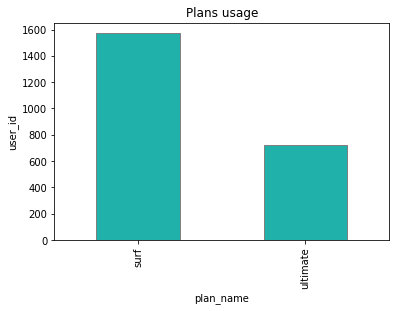

In [68]:
#distribution of plan usage per number of users
aggregated_data['plan_name'].value_counts().plot(kind='bar', figsize=(6,4), color='lightseagreen',edgecolor = "gray", grid=False)
plt.title("Plans usage")
plt.xlabel('plan_name')
plt.ylabel('user_id');

In [69]:
aggregated_data.sort_values('gb_used').tail()

,user_id,month,total_calls_made,total_min_month,messages_sent,gb_used,first_name,last_name,age,city,subscription_date,plan_name,churn_date,customer_churn,subscription_month,year,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,messages_cost,calls_cost,gb_cost,revenue
1486,1240,August,161.0,1095.0,15.0,49.0,Drema,Lopez,61,"Baton Rouge, LA MSA",2018-03-18,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,17.85,340.0,377.85
1659,1292,August,42.0,323.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,0.00,360.0,380.00
1660,1292,December,28.0,144.0,0.0,51.0,Cassey,French,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,surf,NaT,No churn,January,2018,50,15360,500,20,10,0.03,0.03,15.0,0.00,0.00,360.0,380.00
1117,1121,December,0.0,0.0,97.0,66.0,Kathaleen,Albert,34,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-13,surf,NaT,No churn,March,2018,50,15360,500,20,10,0.03,0.03,15.0,1.41,0.00,510.0,531.41
1980,1379,December,144.0,1103.0,126.0,70.0,Jarrett,Spencer,34,"Grand Rapids-Kentwood, MI MSA",2018-10-18,surf,NaT,No churn,October,2018,50,15360,500,20,10,0.03,0.03,15.0,2.28,18.09,550.0,590.37


In [70]:
#filtered data for surf plan
surf_plan_info = aggregated_data.query("plan_name == 'surf'")
surf_plan_info = surf_plan_info[['total_calls_made', 'total_min_month', 'messages_sent', 'gb_used', 'revenue']]

# filtered data for the ultimate plan
ultimate_plan_info = aggregated_data.query("plan_name == 'ultimate'")
ultimate_plan_info = ultimate_plan_info[['total_calls_made', 'total_min_month', 'messages_sent', 'gb_used', 'revenue','month']]



In [71]:
surf_plan_info.describe()

,total_calls_made,total_min_month,messages_sent,gb_used,revenue
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,59.811825,428.749523,31.159568,16.670693,60.706408
std,32.017989,234.453150,33.566717,7.847522,55.388042
min,0.000000,0.000000,0.000000,0.000000,20.000000
25%,39.000000,272.000000,3.000000,12.000000,20.000000
50%,60.000000,425.000000,24.000000,17.000000,40.360000
75%,79.000000,576.000000,47.000000,21.000000,80.360000
max,205.000000,1510.000000,266.000000,70.000000,590.370000


In [72]:
ultimate_plan_info.describe()

,total_calls_made,total_min_month,messages_sent,gb_used,revenue
count,720.000000,720.000000,720.000000,720.000000,720.000000
mean,60.626389,430.450000,37.551389,17.306944,72.313889
std,33.242994,240.508762,34.767179,7.670108,11.395108
min,0.000000,0.000000,0.000000,0.000000,70.000000
25%,36.000000,260.000000,7.000000,13.000000,70.000000
50%,61.000000,424.000000,30.000000,17.000000,70.000000
75%,80.000000,565.250000,61.000000,21.000000,70.000000
max,191.000000,1369.000000,166.000000,46.000000,182.000000


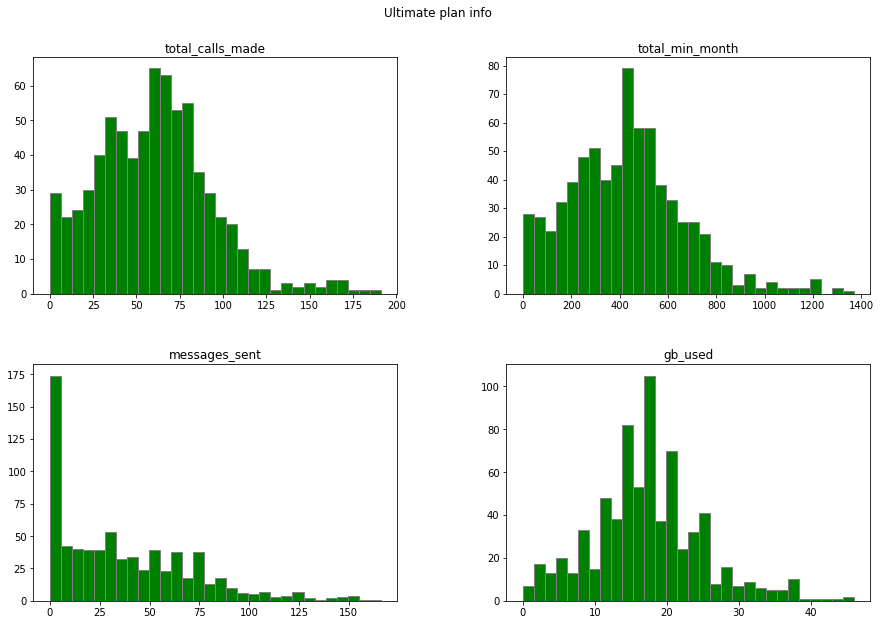

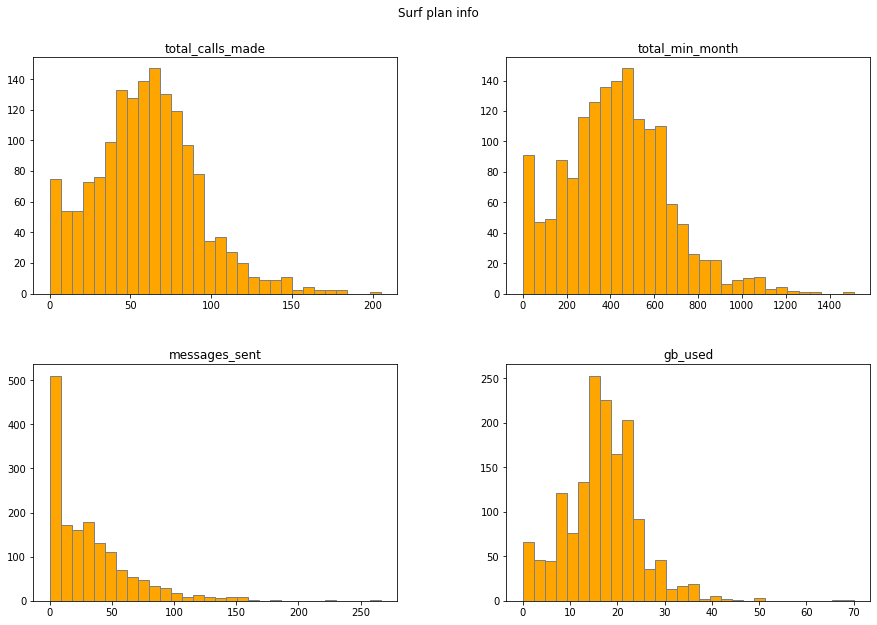

In [73]:
#histogram for filtered data
ultimate_plan_info[['total_calls_made', 'total_min_month', 'messages_sent', 'gb_used']].hist(bins=30, figsize=(15, 10), color='green',edgecolor = "gray", grid=False)
plt.suptitle('Ultimate plan info', y=0.95);


surf_plan_info[['total_calls_made', 'total_min_month', 'messages_sent', 'gb_used']].hist(bins=30, figsize=(15, 10), color='orange',edgecolor = "gray", grid=False)
plt.suptitle('Surf plan info', y=0.95);


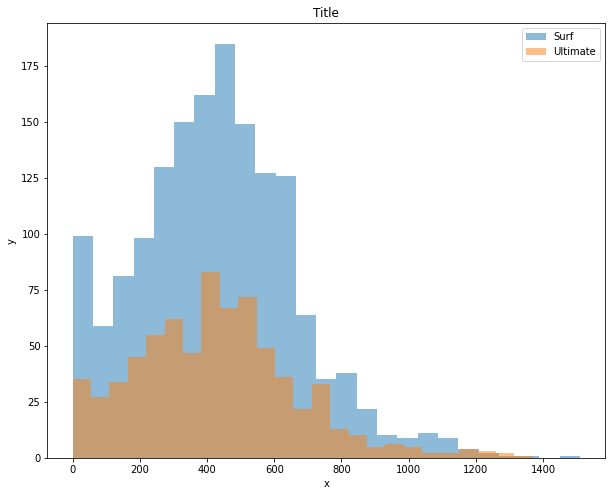

In [74]:
# Reviewer's code


aggregated_data.groupby('plan_name')['total_min_month'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Title')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

,gb_used,messages_sent,total_calls_made,total_min_month
plan_name,,,,
surf,16.670693,31.159568,59.811825,428.749523
ultimate,17.306944,37.551389,60.626389,430.450000


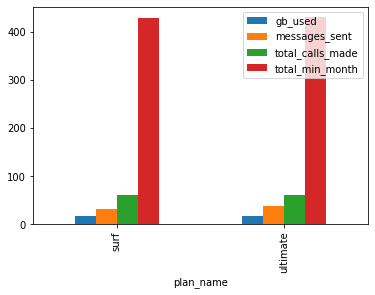

In [75]:
#average data use per plan
usage_data = aggregated_data.pivot_table(index='plan_name', values=['total_calls_made', 'total_min_month', 'messages_sent', 'gb_used'], aggfunc='mean')
display(usage_data)
usage_data.plot(kind='bar');

In [76]:
def user_behaviour(behavior):
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(
        aggregated_data, 
        x=behavior, 
        hue="plan_name", 
        kde=True, 
        palette="husl"
    )

    mean=aggregated_data[behavior].mean()
    std=aggregated_data[behavior].std()
    var=aggregated_data[behavior].var()
    cv=std/mean
    plt.show()
    print("Average is",mean)
    print(aggregated_data.groupby(['plan_name'])[behavior].mean())
    print()
    print(aggregated_data.groupby(['plan_name'])[behavior].std())
    print()
    print(aggregated_data.groupby(['plan_name'])[behavior].var())
    print()
    if cv>1:
        print("Varies a lot")
    else:
        print("Centered around average")

### Calls

#### Total min per month

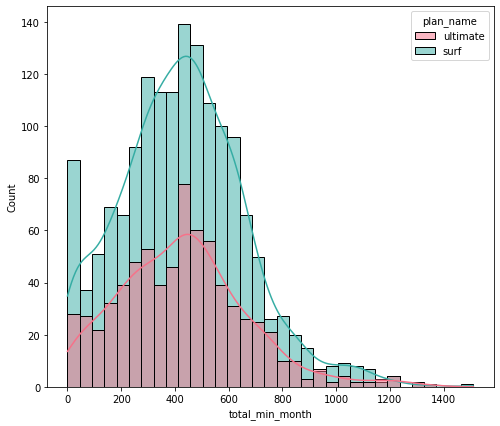

Average is 429.2834714348016
plan_name
surf        428.749523
ultimate    430.450000
Name: total_min_month, dtype: float64

plan_name
surf        234.453150
ultimate    240.508762
Name: total_min_month, dtype: float64

plan_name
surf        54968.279461
ultimate    57844.464812
Name: total_min_month, dtype: float64

Centered around average


In [77]:
#total minutes per month and plan
user_behaviour('total_min_month')

#### Total calls per month

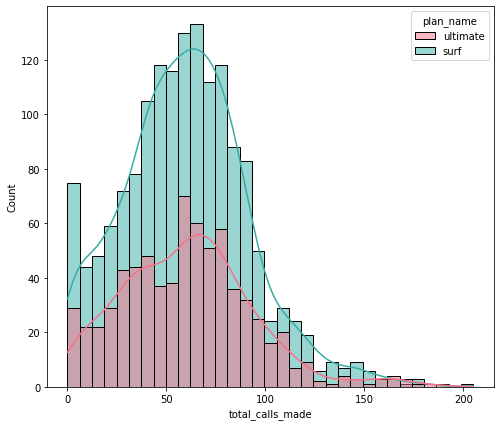

Average is 60.06759703445268
plan_name
surf        59.811825
ultimate    60.626389
Name: total_calls_made, dtype: float64

plan_name
surf        32.017989
ultimate    33.242994
Name: total_calls_made, dtype: float64

plan_name
surf        1025.15159
ultimate    1105.09666
Name: total_calls_made, dtype: float64

Centered around average


In [78]:
user_behaviour('total_calls_made')

In [79]:
print('Percentage of Surf plan users who use more call minutes than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='surf', 'total_min_month']>500).mean()))
print('Percentage of Ultimate plan users who use more call minutes than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='ultimate', 'total_min_month']>3000).mean()))

Percentage of Surf plan users who use more call minutes than provided in the plan: 35.98%
Percentage of Ultimate plan users who use more call minutes than provided in the plan: 0.00%


### Messages

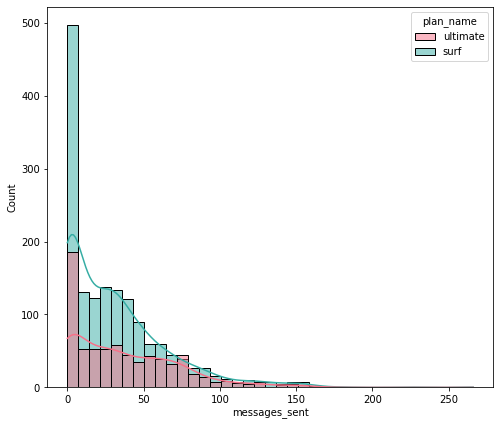

Average is 33.166593981683384
plan_name
surf        31.159568
ultimate    37.551389
Name: messages_sent, dtype: float64

plan_name
surf        33.566717
ultimate    34.767179
Name: messages_sent, dtype: float64

plan_name
surf        1126.724522
ultimate    1208.756744
Name: messages_sent, dtype: float64

Varies a lot


In [80]:
user_behaviour('messages_sent')

In [81]:
print('Percentage of Surf plan users who use more messages than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='surf', 'messages_sent']>50).mean()))
print('Percentage of Ultimate plan users who use more messages than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='ultimate', 'messages_sent']>1000).mean()))


Percentage of Surf plan users who use more messages than provided in the plan: 21.61%
Percentage of Ultimate plan users who use more messages than provided in the plan: 0.00%


### Internet

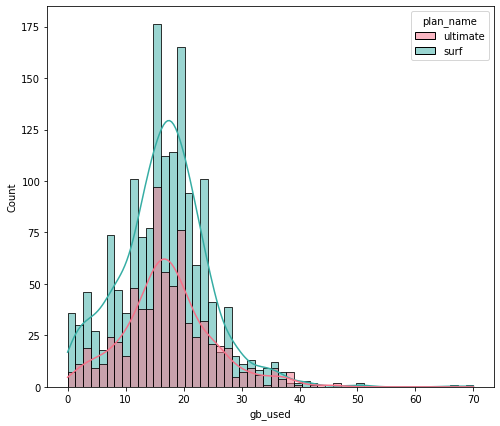

Average is 16.870475359790667
plan_name
surf        16.670693
ultimate    17.306944
Name: gb_used, dtype: float64

plan_name
surf        7.847522
ultimate    7.670108
Name: gb_used, dtype: float64

plan_name
surf        61.58360
ultimate    58.83055
Name: gb_used, dtype: float64

Centered around average


In [82]:
user_behaviour('gb_used')

In [83]:
print('Percentage of Surf plan users who use more GB than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='surf', 'gb_used']>15).mean()))
print('Percentage of Ultimate plan users who use more GB than provided in the plan: {:.2%}'.format((aggregated_data.loc[aggregated_data['plan_name']=='ultimate', 'gb_used']>30).mean()))


Percentage of Surf plan users who use more GB than provided in the plan: 57.91%
Percentage of Ultimate plan users who use more GB than provided in the plan: 5.69%


### Revenue

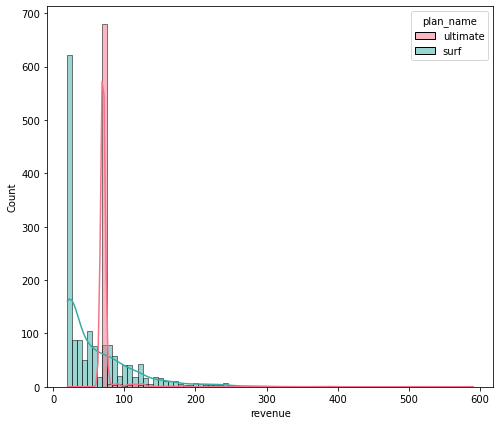

Average is 64.3511469690362
plan_name
surf        60.706408
ultimate    72.313889
Name: revenue, dtype: float64

plan_name
surf        55.388042
ultimate    11.395108
Name: revenue, dtype: float64

plan_name
surf        3067.835152
ultimate     129.848486
Name: revenue, dtype: float64

Centered around average


In [84]:
user_behaviour('revenue')

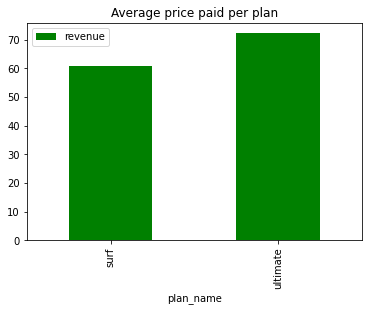

In [85]:
pivot_plan = aggregated_data.pivot_table(index=['plan_name'], values='revenue', aggfunc='mean')
pivot_plan.plot(kind='bar', color='green')
plt.title('Average price paid per plan');


In [86]:
# Reviewer's code

aggregated_data.pivot_table(index='plan_name', values=['total_min_month', 'messages_sent', 'gb_used','total_calls_made'],
                       aggfunc=['mean', 'std', 'var'])

mean                                                      std  \
             gb_used messages_sent total_calls_made total_min_month   gb_used   
plan_name                                                                       
surf       16.670693     31.159568        59.811825      428.749523  7.847522   
ultimate   17.306944     37.551389        60.626389      430.450000  7.670108   

                                                               var  \
          messages_sent total_calls_made total_min_month   gb_used   
plan_name                                                            
surf          33.566717        32.017989      234.453150  61.58360   
ultimate      34.767179        33.242994      240.508762  58.83055   

                                                          
          messages_sent total_calls_made total_min_month  
plan_name                                                 
surf        1126.724522       1025.15159    54968.279461  
ultimate    1208.756744       1105.09666    57844.464812

### Conclusions :

<span style="color:green">**General:** </span> 

- Surf plan users use more minutes than the call limit included in their plan and more messages than provided in their plan. Surf users also use mpre internet gb than the provided in the plan.
- Regarding the revenue, we can see that only in the Surf plan there's a change, since users in this plan pass the limit included in their plan and therefore, the monthly pay of the plan increases, while Ultimate users do not pass the limit so easily
- We can see from the distribution that users in Surf plan pass the limit included in the plan in calls, messages and internet. The average usage per plan is pretty similar
- The usage of internet for both plans is very similar, when the difference in the plan package is very different (15GB vs 30gb a month)

**Ultimate plan: -on average-**

* 60 calls
* 430 minutes per month,
* send 37 messages
* use almost 17gb per month
* variance of: 
    * calls made = 898.79, 
    * messages sent = 978

**Surf plan: -on average-**

* 59 calls
* 428 minutes per month,
* send 31 messages
* use 16 mb per month
* variance of: 
    * calls made = 918.90
    * messages sent = 807



## Test statistical hypotheses

**Hypothesis:**  the average revenue from users in the NY-NJ area is different from that of the users from the other regions
- The null hypothesess is the average revenue from users of Ultimate and Surf calling plans are same. 
    * **H0**: Average revenue per month for Ultimate users = Average revenue per month for Surf user
    * **H1**: Average revenue per month for Ultimate users != Average revenue per month for Surf users
    
    alpha = 0.05

    If
    * p-value < alpha: reject H0
    * p-value > alpha: fail to reject H0


In [87]:
# Test the hypotheses
surf_plan_info = aggregated_data.loc[aggregated_data['plan_name']=='surf', 'revenue']
ultimate_plan_info = aggregated_data.loc[aggregated_data['plan_name']=='ultimate', 'revenue']

In [88]:
alpha = 0.05

In [89]:
results = st.ttest_ind(surf_plan_info, ultimate_plan_info, equal_var = False)
print('p-value = {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")


p-value = 3.17039054811355e-15
We reject the null hypothesis


<span style="color:green">**Notes from the analyst:** </span> 

- The average revenue from users in Surf and Ultimate plans are different. 


- The **alternative** one is that the average revenue from users of Ultimate and Surf calling plans are different
    * **H0**: The average revenue from users in NY-NJ area = Average revenue for users from other region
    * **H1:** The average revenue from users in NY-NJ area != Average revenue for users from other regions

alpha = 0.05

In [90]:
NY_NJ_data = aggregated_data.loc[aggregated_data['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA', 'revenue']
rest = aggregated_data.loc[aggregated_data['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA', 'revenue']


In [91]:
alpha = 0.05

results_2 = st.ttest_ind(NY_NJ_data, rest)
print('p-value = {}'.format(results_2.pvalue))

if (results_2.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value = 0.04355743162134299
We reject the null hypothesis


In [92]:
# revenue of users in NY-NJ
print('The average revenue from users in NY-NJ area: ', NY_NJ_data.mean())
print('The average revenue from users not from NY_NJ: ', rest.mean())

The average revenue from users in NY-NJ area:  59.921352785145885
The average revenue from users not from NY_NJ:  65.22277139874738


<span style="color:green">**Notes from the analyst:** </span> 

- Average revenue from users in the NY-NJ area is different from the users in other regions
- Average revenue from other regions than NY-NJ is actually higher that NY-NJ users
- For our test hypothesis we used t-test and a significance level of 0.05.
- We conclude that the mean of the revenue between NY-NJ newjersey is different from the mean of the revenue from other areas althought we don't have any information about how much they are different.

## General conclusion



We worked with 5 separate datasets. We cleaned and calculated:

- Calls:
    - total calls made per month and user
    - total minutes spent per month and user
- Messages:
    - total messages sent per month and user
- Internet: 
    - total gb used per month and user
    
- Monthy revenue per user. 

We described the user's behavior on the usage of the call minutes, messages and internet included and compared to each plan. We calculated the mean, variance and standard deviation, plotting histograms and understand the distribution. 

In the analysis we saw some differences in the behavior of the users per plan:

- **Calls:** 35% of Surf users pass the limit of calls provided in the plan, against 0% from Ultimate users, who did not pass it
- **Messages:** 21% of Surf users pass the limit of messages provided in the plan, against 0% from Ultimate users. 
- **Internet:** 57% of Surf users pass the 15GB limit, while only 5% of Ultimate users pass the 30GB limit. 


We tested two hypotheses:

1. The average revenue from users of Ultimate and Surf calling plans differs
1. The average revenue from users in NY-NJ area is different from that of the users from other regions.

We can conclude:
That Surf users have a cheaper plan but end up needing more GB, minutes and messages per month. While Ultimate user have a better usage of their plan. 
